In [1]:
import pandas as pd
import numpy as np

In [18]:
df = pd.read_csv("HistoricalQuotes.csv")

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    253 non-null    object 
 1   close   253 non-null    float64
 2   volume  253 non-null    int64  
 3   open    253 non-null    float64
 4   high    253 non-null    float64
 5   low     253 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 12.0+ KB


In [20]:
df.head()

,date,close,volume,open,high,low
0,10-08-2019,200.99,24619446,201.23,202.760,199.29
1,09-08-2019,200.99,24619750,201.30,202.760,199.29
2,08-08-2019,203.43,27009520,200.20,203.530,199.39
3,07-08-2019,199.04,33364400,195.41,199.560,193.82
4,06-08-2019,197.00,35824790,196.31,198.067,194.04


In [21]:
df['date'] = pd.to_datetime(df['date'],format="mixed",dayfirst=True)

In [22]:
df.set_index('date',inplace=True)

In [23]:
df.sort_index(inplace=True)

In [24]:
df.isnull().sum()

close     0
volume    0
open      0
high      0
low       0
dtype: int64

## Step 2 ::use asfreq function in pandas and store result in new data frame

this function is going to check if all the time values ( dates / hrs / mins / months ) are present 

if any time value is missing , then it creates a new row for that missing value and fills it with NaN

In [25]:
df = df.asfreq('B') #Buiseness Days

In [26]:
df.isnull().sum()

close     10
volume    10
open      10
high      10
low       10
dtype: int64

## Step 3 :: Fill the missing values ( Don't use median / mode / mean)

- what to use to fill ??

previous day (frontfill)  or next day value  (backfill)

In [28]:
df.fillna(method='ffill', inplace=True) # fill missing with previous days values

C:\Users\dbda\AppData\Local\Temp\ipykernel_10284\632807382.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True) # fill missing with previous days values


In [29]:
df.isnull().sum()

close     0
volume    0
open      0
high      0
low       0
dtype: int64

# Decompose the time series


Time series is made up of 

- Trend -> moving average

average value of last few observations 

ex. what is trend of last week sales , whats trend of last month share market ,etc

- Seasonality -> repeatition pattern

ex. seasonal sales of rain coat, sales on festivals ( diwali), rainy season, etc

- Residue / noise --> random value which cannot be modeled

This will always induce error so TS model never has 0 error


Two types of time series 

- Additive

TS Value = Trend + Seasonality + noise

- Multiplicative 

TS value = Trend * Seasonality * noise

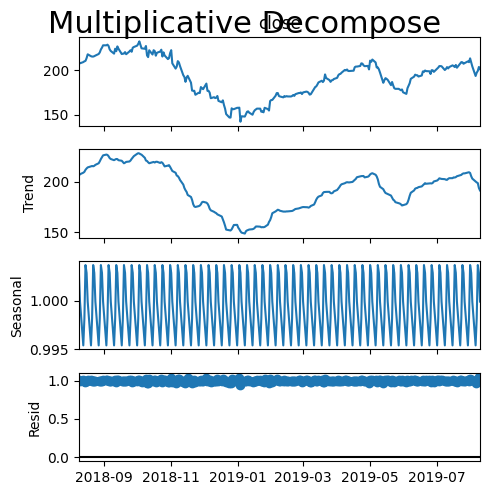

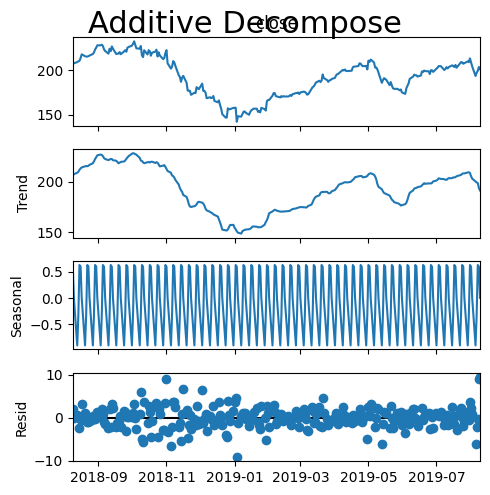

In [32]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['close'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['close'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (5,5)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Note :: Simple method to detect is multiplicative or additive model

Compare the noise / residue of both models

The model which has repeatitions in residue that is wrong model

IN THIS CASE both models are working perfectly so choose any

## Create the features

 how many ? --> you can do trial and error

 here we will consider 5

In [33]:
ts_data = df[['close']].copy()
ts_data.shape

(262, 1)

In [34]:
ts_data['close_t_1'] = ts_data['close'].shift(1) # shift one value below
ts_data['close_t_2'] = ts_data['close'].shift(2) # shift one value below
ts_data['close_t_3'] = ts_data['close'].shift(3) # shift one value below
ts_data['close_t_4'] = ts_data['close'].shift(4) # shift one value below
ts_data['close_t_5'] = ts_data['close'].shift(5) # shift one value below

In [35]:
ts_data.head(7)

,close,close_t_1,close_t_2,close_t_3,close_t_4,close_t_5
date,,,,,,
2018-08-09,208.88,NaN,NaN,NaN,NaN,NaN
2018-08-10,207.53,208.88,NaN,NaN,NaN,NaN
2018-08-13,208.87,207.53,208.88,NaN,NaN,NaN
2018-08-14,209.75,208.87,207.53,208.88,NaN,NaN
2018-08-15,210.24,209.75,208.87,207.53,208.88,NaN
2018-08-16,213.32,210.24,209.75,208.87,207.53,208.88
2018-08-17,217.58,213.32,210.24,209.75,208.87,207.53


In [36]:
ts_data.dropna(inplace=True)

# After creating features its like normal tabular data for regression problem

## X & Y , train test split

In [37]:
Y = ts_data['close']
X = ts_data.drop('close',axis=1)

In [38]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.3, random_state=7)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((179, 5), (78, 5), (179,), (78,))

In [39]:
def eval_fun(Y_test,Y_pred):
    from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
    # r2 = r2_score(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    mae = mean_absolute_error(Y_test,Y_pred)
    return mse, mae

In [40]:
# create a RF regressor
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50,max_depth=5, oob_score=True,random_state=7)
rf.fit(X_train,Y_train)

RandomForestRegressor(max_depth=5, n_estimators=50, oob_score=True,
                      random_state=7)

In [41]:
Y_pred_rf = rf.predict(X_test)

In [42]:
mse, mae = eval_fun(Y_test,Y_pred_rf) 
print("mse = ", mse, " mae =", mae)

mse =  17.09644146642519  mae = 3.126545354949534


In [43]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(max_depth= 5, n_estimators= 50, subsample= 0.8,random_state=7)
gbr.fit(X_train,Y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=50, random_state=7,
                          subsample=0.8)

In [44]:
Y_pred_gbr = gbr.predict(X_test)

In [45]:
mse, mae = eval_fun(Y_test,Y_pred_gbr) 
print( "mse = ", mse, " mae =", mae)

mse =  19.313269145529073  mae = 3.3705146947468676


In [46]:
res = pd.DataFrame([Y_test.values, Y_pred_rf, Y_pred_gbr]).T
res.columns = ['Y_test', 'Y_pred_rf', 'Y_pred_gbr']
res.shape

(78, 3)

<Axes: >

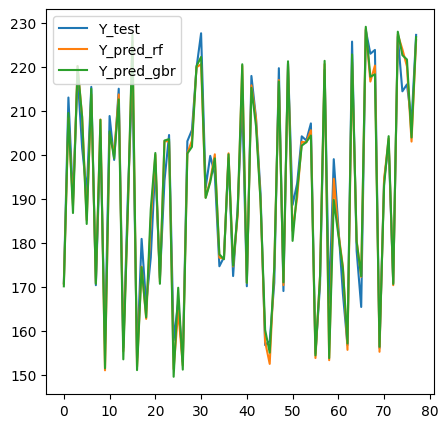

In [47]:
res.plot()

# LSTM

## Imp implementation details for RNN / LSTM

inputs are processed sequentially and not all together

Ex. if there are 5 features X t-1, X t-2, x t-3, x t-4 , x t-5

here , we don't give all 5 features at once

first x t-1 goes then x t-2 .... one by one

So, to achieve this LSTM input need to be in form of a queue / sequence and not as simple array

ex. [1,2,3,4] --> this will not work

[[1], [2], [3], [4]]  --> like this we can access one value at a time

In [48]:
import tensorflow as tf
from tensorflow import keras

In [49]:
X_train[:3].values

array([[178.58, 179.55, 180.94, 174.24, 174.62],
       [192.74, 194.15, 194.19, 194.81, 192.58],
       [166.52, 166.44, 165.25, 154.68, 156.3 ]])

In [50]:
# reshape the training features and test features to suit input format of RNN / LSTM
# here we add extra dim to X_train and X_test
import numpy as np
X_train = np.reshape(X_train.values, (X_train.shape[0],X_train.shape[1], 1))

In [51]:
X_train[:3]

array([[[178.58],
        [179.55],
        [180.94],
        [174.24],
        [174.62]],

       [[192.74],
        [194.15],
        [194.19],
        [194.81],
        [192.58]],

       [[166.52],
        [166.44],
        [165.25],
        [154.68],
        [156.3 ]]])

## LSTM with single neuron

Lets check power of a single neuron of LSTM

In [61]:
model = keras.Sequential()

# Adding LSTM layers
model.add(keras.layers.LSTM(units=1,return_sequences = False, 
                            input_shape= (X_train.shape[1],X_train.shape[2])))
# Adding the output layer
model.add( keras.layers.Dense(1, activation='linear'))

# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

C:\Users\dbda\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train, validation_split=0.2,epochs = 1000, batch_size = 5)

Epoch 1/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 32612.1914 - val_loss: 34277.9844
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33635.7344 - val_loss: 34267.3398
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34020.5469 - val_loss: 34256.7500
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34044.1406 - val_loss: 34246.1016
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33912.3086 - val_loss: 34235.5039
Epoch 6/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35257.2734 - val_loss: 34224.8945
Epoch 7/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34772.9258 - val_loss: 34214.3281
Epoch 8/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34188.9336 - val_loss: 34203.7539
Epoch 9/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34601.6641 - val_loss: 34193.1484
Epoch 10/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34417.4609 - val_loss: 34182.5820
Epoch 11/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

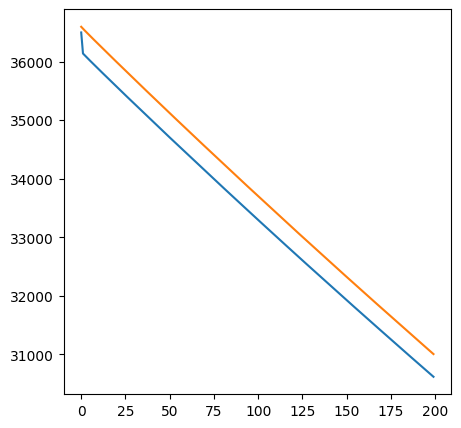

In [99]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Multi layer LSTM

HL 1 --> 10 LSTM neurons

HL 2 --> 5

Output Layer --> dense layer 1 neuron activation => linear

In [97]:
model = keras.Sequential()

# Adding LSTM layers
model.add(keras.layers.LSTM(units=200,return_sequences = False, 
                            input_shape= (X_train.shape[1],X_train.shape[2])))

#model.add(keras.layers.LSTM(units=5,return_sequences = False))
# Adding the output layer
model.add( keras.layers.Dense(1, activation='linear'))

# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

C:\Users\dbda\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [98]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 200)                 │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,801 (632.04 KB)

 Trainable params: 161,801 (632.04 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
history = model.fit(X_train, Y_train, validation_split=0.3,epochs = 200, batch_size = 10)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 36706.5781 - val_loss: 36459.2344
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 36371.5430 - val_loss: 35559.5273
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 34531.6992 - val_loss: 34057.3672
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 32887.9727 - val_loss: 32210.8203
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 32157.5039 - val_loss: 31079.5859
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 30811.9219 - val_loss: 29950.7480
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 29483.7715 - val_loss: 29016.7207
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 28573.3027 - val_loss: 28117.5078
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 27111.1738 - val_loss: 27290.6289
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 26324.8438 - val_loss: 26527.2207
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss

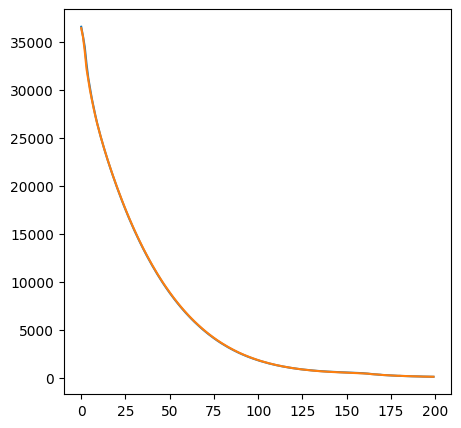

In [102]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])